# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Будут использованы данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Описание данных**

**Технологический процесс**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag
Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

**Цель**

Нужно спрогнозировать две величины:

1. эффективность обогащения чернового концентрата rougher.output.recovery;
2. эффективность обогащения финального концентрата final.output.recovery.

План работы:

1. Подготовить данные
- изучить общую информацию;
- проверить эффективность обогащения;
- проанализировать признаки;
- провести предобработку данных.
2. Провести исследовательский анализ данных
- проверить концентрацию металлов на разных этапах очистки;
- сравнить распределения размеров гранул сырья на обучающей и тестовой выборках;
- исследовать суммарную концентрацию всех веществ на рахных стадиях.
3. Построить и обучить модель
- написать функцию для вычисдения sMAPE;
- обцчить разные модели, выбрать лучшую.

## Подготовка данных

### Изучение общей информации

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from numpy.random import RandomState
STATE = RandomState(12345)

In [2]:
# загрузим файлы

try:
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
except:
    data_full = pd.read_csv('gold_recovery_full_new.csv')
    data_train = pd.read_csv('gold_recovery_train_new.csv')
    data_test = pd.read_csv('gold_recovery_test_new.csv')

display(data_full.head())
display(data_train.head())
display(data_test.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [3]:
# проверим размеры выборок

display(f'Исходные данные: столбцов {data_full.shape[1]}, строк {data_full.shape[0]}')
display(f'Обучающая выборка: столбцов {data_train.shape[1]}, строк {data_train.shape[0]}')
display(f'Тестовая выборка: столбцов {data_test.shape[1]}, строк {data_test.shape[0]}')

'Исходные данные: столбцов 87, строк 19439'

'Обучающая выборка: столбцов 87, строк 14149'

'Тестовая выборка: столбцов 53, строк 5290'

In [4]:
# изучим выборки

display(data_full.info())
display(data_train.info())
display(data_test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

In [5]:
# применим метод describe и продолжим изучение
print('Исходные данные')
print()
display(data_full.describe())
print()

print('Обучающая выборка')
print()
display(data_test.describe())
print()

print('Тестовая выборка')
print()
display(data_train.describe())
print()

Исходные данные



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459



Обучающая выборка



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487



Тестовая выборка



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [6]:
# проверим дубликаты в каждой выборке

display(f'В исходных данных {data_full.duplicated().sum()} дубликатов')
display(f'В обучающей выборке {data_train.duplicated().sum()} дубликатов')
display(f'В тестовой выборке {data_test.duplicated().sum()} дубликатов')


'В исходных данных 0 дубликатов'

'В обучающей выборке 0 дубликатов'

'В тестовой выборке 0 дубликатов'

In [7]:
# проверим пропуски в каждой выборке

display(data_full.isna().sum())
display(data_train.isna().sum())
display(data_test.isna().sum())


date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

**Вывод**

У нас есть три таблицы с данными - исходными, обучающими и тестовыми. В исходных данных 19,5 тыс. строк и 87 столбцов, в обучающей выборке чуть больше - 14 тыс. строк и 87 столбцов, а в тестовой выборке всего 5,3 тыс. строк и 53 столбца (отсутствующие столбцы в тестовой выборке - значения, которые замеряются или расчитываются)

Все значения в столбцах имеют тип данных float, кроме даты - этот столбец типа object. Также таблицы отсортированы по дате в проядке возрастания.

В данных также есть незначительное количество пропусков. Их можно заменить на соседние по времени.


### Расчет эффективности обогащения

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака **rougher.output.recovery**. Найдем MAE между расчётами и значением признака.

In [8]:
# напишем функцию для расчета эффективности обогащения

def recovery_function(c, f, t):

    recovery = ((c*(f-t)) / (f*(c-t))) * 100
    return recovery

In [9]:
# применим функцию к нужным столбцам и расчитаем MAE

recovery_train = recovery_function(data_train['rougher.output.concentrate_au'], \
    data_train['rougher.input.feed_au'], data_train['rougher.output.tail_au'])

mae = mean_absolute_error(data_train['rougher.output.recovery'].fillna(0), recovery_train)

print('MAE:', mae)


MAE: 9.73512347450521e-15


Эффективность обогащения рассчитана верно.

### Анализ тестовой выборки

Проанализируем признаки, недоступные в тестовой выборке.

In [10]:
# сравним названия столбцов в тестовой выборке с названиями в исходных данных

all_cols = data_train.columns
test_cols = data_test.columns

common_cols = all_cols.intersection(test_cols)
all_not_test = all_cols.difference(test_cols)

print(f'Количество общих столбцов в двух выборках: {len(common_cols)}')
print()
print(list(common_cols))

print()
print(f'Количество отсутствующих столбцов в тестовой выборке: {len(all_not_test)}')
print()
print(list(all_not_test))



Количество общих столбцов в двух выборках: 53

['date', 'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.stat

**Вывод**

Признаки, недоступные в тестовой выборке относятся к параметрам, которые замеряются и/или рассчитываются намного позже. Пробежав взглядом по списку отсутствующих столбцов, можно выделить этапы **output** и **calculation** . В таком случае мы можем убрать из обучающей выборки эти столбцы для корректной работы с моделями.

### Предобработка данных

In [11]:
# Удалим столбцы в обучающей выборке, которых нет в тестовой 

data_train = data_train.drop(all_not_test, axis=1)

# проверим те ли столбцы мы удалили 

all_cols = data_train.columns
test_cols = data_test.columns

common_cols = all_cols.intersection(test_cols)
all_not_test = all_cols.difference(test_cols)

print(f'Количество общих столбцов в двух выборках: {len(common_cols)}')
print()
print(f'Количество отсутствующих столбцов в тестовой выборке: {len(all_not_test)}')

Количество общих столбцов в двух выборках: 53

Количество отсутствующих столбцов в тестовой выборке: 0


In [12]:
# заменим пропуски в тестовой и обучающей выборках

data_test = data_test.fillna(axis = 0, method='ffill')
data_train = data_train.fillna(axis = 0, method='ffill')

display(data_test)
display(data_train)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5286,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5287,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5288,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
14145,2018-08-18 07:59:59,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
14146,2018-08-18 08:59:59,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
14147,2018-08-18 09:59:59,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [13]:
# удалим пропущенные значения

#data_test.dropna(axis=0, inplace=True)
#data_train.dropna(axis=0, inplace=True)

#data_test.reset_index()
#data_train.reset_index()


In [14]:
print(f'Размер тестовой выборки: {data_test.shape}')
print()
print(f'Размер обучающей выборки: {data_train.shape}')

Размер тестовой выборки: (5290, 53)

Размер обучающей выборки: (14149, 53)


**Вывод**

В процессе предобработки данных удалили в обучающей выборке столбцы, отсутствующие в тестовой выборке. Заменили пропущенные значения использовав метод 'ffill' в обеих выборках.

## Анализ данных

### Изменения концетрации металлов (Au, Ag, Pb) на различных этапах очистки

In [15]:
# запишем необходимые столбцы в переменные

au = data_full[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
ag = data_full[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
pb = data_full[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]


label_names = ['Флотация', 'Первичная обработка', 'Финальная обработка']

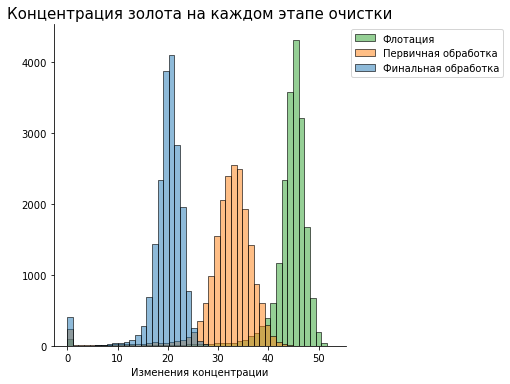

In [16]:
# построим график для золота

ax = sns.displot(au, legend = False)
plt.legend(labels = label_names, loc = 2, bbox_to_anchor = (1,1))

plt.title('Концентрация золота на каждом этапе очистки', fontsize=15)
plt.xlabel('Изменения концентрации', fontsize=10)
plt.ylabel('')
plt.show()

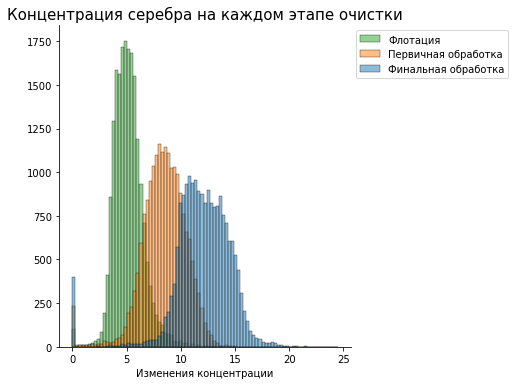

In [17]:
# построим график для серебра

ax = sns.displot(ag, legend = False)
plt.legend(labels = label_names, loc = 2, bbox_to_anchor = (1,1))

plt.title('Концентрация серебра на каждом этапе очистки', fontsize=15)
plt.xlabel('Изменения концентрации', fontsize=10)
plt.ylabel('')
plt.show()



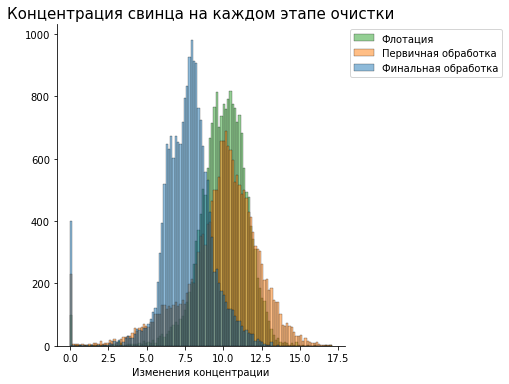

In [18]:
# построим график для свинца

ax = sns.displot(pb, legend = False)
plt.legend(labels = label_names, loc = 2, bbox_to_anchor = (1,1))

plt.title('Концентрация свинца на каждом этапе очистки', fontsize=15)
plt.xlabel('Изменения концентрации', fontsize=10)
plt.ylabel('')
plt.show()



- Концентрация золота к финальной стадии обработки возрастает.
- Концентрация серебра к финальной стадии обработки уменьшается.
- Концентрация свинца к финальной стадии немного увеличивается.

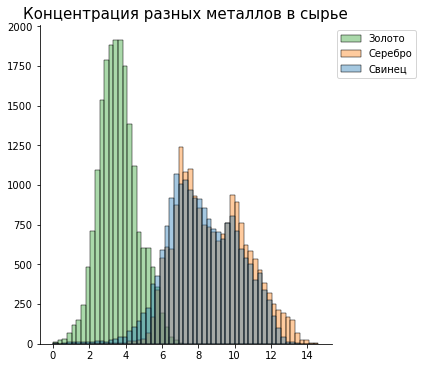

In [19]:
# проверим концентрацию разных металлов в сырье

input_feed = data_full[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']]

label_names = ['Золото', 'Серебро', 'Свинец']

ax = sns.displot(input_feed, legend = False, alpha=0.4)
plt.legend(labels = label_names, loc = 2, bbox_to_anchor = (1,1))

plt.title('Концентрация разных металлов в сырье', fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.show()



### Сравнение распределений размеров гранул сырья на выборках

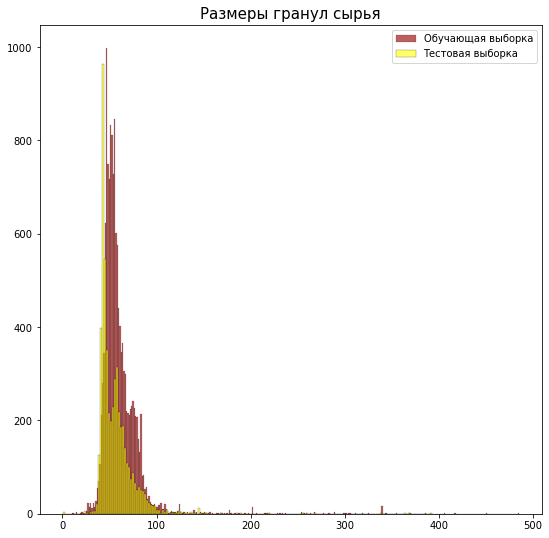

In [20]:
# построим распределения

plt.figure(figsize=(9,9))
sns.histplot(data_train['rougher.input.feed_size'], color='brown')
sns.histplot(data_test['rougher.input.feed_size'], color='yellow', alpha=0.6)
plt.legend(labels = ('Обучающая выборка', 'Тестовая выборка'))

plt.title('Размеры гранул сырья', fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.show()


- Распределения размеров гранул сырья отличаются не сильно.

### Суммарная концентрация всех веществ на разных стадиях

In [21]:
# выберем столбцы с веществами на стадиях - сырье, черновая и финальная

rougher_input = data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_ag'] + \
    data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_sol']

rougher_output = data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_ag'] + \
    data_full['rougher.output.concentrate_pb'] + data_full['rougher.output.concentrate_sol']

final_output = data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag'] + \
    data_full['final.output.concentrate_pb'] + data_full['final.output.concentrate_sol']

labels = ['Сырье', 'Черновая', 'Финальная']


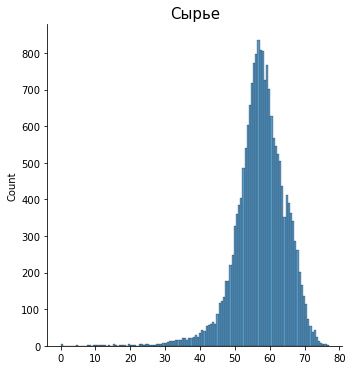

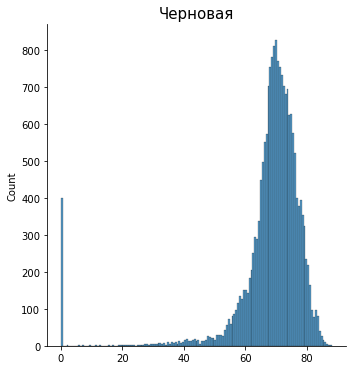

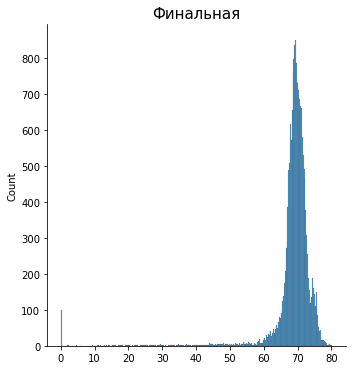

In [22]:
# построим графики

for i, j in zip(list([rougher_input, rougher_output, final_output]), labels):
    sns.displot(i)
    plt.title(j, fontsize=15)
    
    plt.show()

- По графикам заметны нулевые значения - суммарная концентрация должна быть больше нуля.

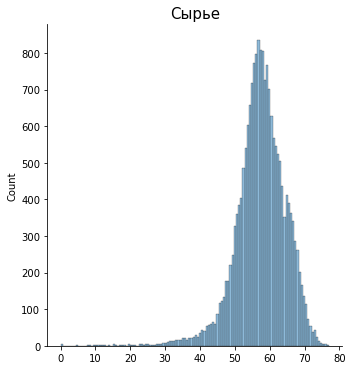

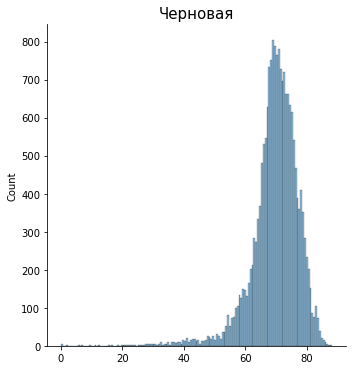

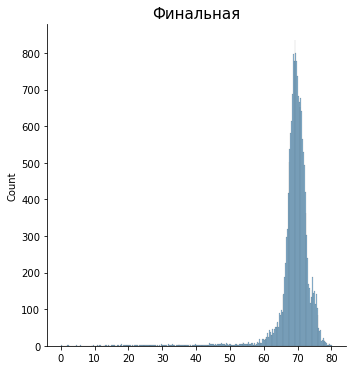

In [23]:
# удалим аномальные значения

rougher_input = pd.DataFrame(data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_ag'] + \
    data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_sol']).replace(0, np.nan).dropna(axis=0)

rougher_output = pd.DataFrame(data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_ag'] + \
    data_full['rougher.output.concentrate_pb'] + data_full['rougher.output.concentrate_sol']).replace(0, np.nan).dropna(axis=0)

final_output = pd.DataFrame(data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag'] + \
    data_full['final.output.concentrate_pb'] + data_full['final.output.concentrate_sol']).replace(0, np.nan).dropna(axis=0)


for i, j in zip([rougher_input, rougher_output, final_output], labels):
    sns.displot(i, legend=False)
    plt.title(j, fontsize=15)
    plt.show()

**Суммарная концентрация веществ к финальной стадии уменьшилась**

## Модель

### Функция для расчета итоговой sMAPE

In [24]:
def smape_function(target, predictions):
    
    smape = ((1/len(target)) * sum(2 * abs(predictions - target) / (abs(target) + abs(predictions)))) * 100

    return smape

### Обучение разных моделей

In [25]:
# столбец с датой не нужен - его удалим 

data_train.drop(['date'], axis=1, inplace=True)
data_test.drop(['date'], axis=1, inplace=True)

In [26]:
# поделим выборки на признаки и целевые признаки 

# для чернового концентрата

features_train_rougher = data_train
target_train_rougher = data_full.loc[features_train_rougher.index, 'rougher.output.recovery']

features_test_rougher = data_test
target_test_rougher = data_full.loc[features_test_rougher.index, 'rougher.output.recovery']

# для финального концентрата

features_train_final = data_train
target_train_final = data_full.loc[features_train_final.index, 'final.output.recovery']

features_test_final = data_test
target_test_final = data_full.loc[features_test_final.index, 'final.output.recovery']

print(features_train_rougher.shape, target_train_rougher.shape, features_test_rougher.shape, target_test_rougher.shape)
print(features_train_final.shape, target_train_final.shape, features_test_final.shape, target_test_final.shape)


(14149, 52) (14149,) (5290, 52) (5290,)
(14149, 52) (14149,) (5290, 52) (5290,)


In [27]:
# подготовим smape для расчетов в моделях

smape_score = make_scorer(smape_function, greater_is_better=False)

In [28]:
# подготовим необходимые параметры для GridSearchCV

cross = KFold(n_splits=5, shuffle=False)



# для RandomForestRegressor

param_RFR = { 'n_estimators': range(1, 51, 10),
        'max_depth': range(1, 10, 2)}



# для LinearRegression

pipe_LR = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

param_LR = {
        'imp__strategy': ['mean', 'median'],
        'model': [LinearRegression()]
    }


# для Lasso

pipe_lasso = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('model', linear_model.Lasso())
])

param_lasso = { 
        'imp__strategy': ['mean', 'median'],
        'model': [linear_model.Lasso()],
        'model__alpha': np.logspace(-1, 1, 10)
    }

#### RandomForestRegressor

In [29]:
# найдем лучшие параметры на черновом концентрате

RFR_rouhger = RandomForestRegressor(random_state=STATE)
grid_RFR = GridSearchCV(RFR_rouhger, param_RFR, cv=cross, scoring=smape_score)
grid_RFR_rouhger = grid_RFR.fit(features_train_rougher, target_train_rougher)

print(f'Best params: {grid_RFR_rouhger.best_params_}')
print(f'Best smape score: {-grid_RFR_rouhger.best_score_}')

Best params: {'max_depth': 3, 'n_estimators': 11}
Best smape score: 12.287518430870705


In [30]:
# найдем лучшие параметры на финальном концентрате

grid_RFR_final = grid_RFR.fit(features_train_final, target_train_final)

print(f'Best params: {grid_RFR_final.best_params_}')
print(f'Best smape score: {-grid_RFR_final.best_score_}')

Best params: {'max_depth': 3, 'n_estimators': 41}
Best smape score: 11.215938381822957


#### LinearRegression

In [31]:
# найдем лучшие параметры на черновом концентрате

LR = LinearRegression()
grid_LR = GridSearchCV(pipe_LR, param_grid=param_LR, cv=cross, scoring=smape_score, n_jobs=-1)
grid_LR_rouhger = grid_LR.fit(features_train_rougher, target_train_rougher)

print(f'Best params: {grid_LR_rouhger.best_params_}')
print(f'Best smape score: {-grid_LR_rouhger.best_score_}')

Best params: {'imp__strategy': 'mean', 'model': LinearRegression()}
Best smape score: 14.244532639315375


In [32]:
# найдем лучшие параметры на финальном концентрате

grid_LR_final = grid_LR.fit(features_train_final, target_train_final)

print(f'Best params: {grid_LR_final.best_params_}')
print(f'Best smape score: {-grid_LR_final.best_score_}')

Best params: {'imp__strategy': 'mean', 'model': LinearRegression()}
Best smape score: 12.512332011639288


#### Lasso

In [33]:
# найдем лучшие параметры на черновом концентрате

lasso_model = linear_model.Lasso(random_state=STATE)
grid_lasso = GridSearchCV(pipe_lasso, param_grid=param_lasso, cv=cross, scoring=smape_score, n_jobs=-1)
grid_lasso_rouhger = grid_lasso.fit(features_train_rougher, target_train_rougher)

print(f'Best params: {grid_lasso_rouhger.best_params_}')
print(f'Best smape score: {-grid_lasso_rouhger.best_score_}')

Best params: {'imp__strategy': 'mean', 'model': Lasso(alpha=1.291549665014884), 'model__alpha': 1.291549665014884}
Best smape score: 10.695103047779538


In [34]:
# найдем лучшие параметры на финальном концентрате

grid_lasso_final = grid_lasso.fit(features_train_final, target_train_final)

print(f'Best params: {grid_lasso_final.best_params_}')
print(f'Best smape score: {-grid_lasso_final.best_score_}')

Best params: {'imp__strategy': 'mean', 'model': Lasso(alpha=0.774263682681127), 'model__alpha': 0.774263682681127}
Best smape score: 10.666136057725186


**Исходя из результатов работы GridSearchCV выбираем модель Lasso. Эта модель показала наименьший итоговый SMAPE.**

#### Проверим модель на тестовой выборке и расчитаем итоговый SMAPE

In [35]:
model_rougher = linear_model.Lasso(random_state=STATE, alpha=1.3)
model_rougher.fit(features_train_rougher, target_train_rougher)
predictions_rougher = model_rougher.predict(features_test_rougher)

smape_rougher = smape_function(target_test_rougher, predictions_rougher)

print(f'SMAPE для тестовой выборки (черновой концентрат): {smape_rougher}')

SMAPE для тестовой выборки (черновой концентрат): 12.718480465090435


In [36]:
model_final = linear_model.Lasso(random_state=STATE, alpha=3.6)
model_final.fit(features_train_final, target_train_final)
predictions_final = model_final.predict(features_test_final)

smape_final = smape_function(target_test_final, predictions_final)

print(f'SMAPE для тестовой выборки (финальный концентрат): {smape_final}')

SMAPE для тестовой выборки (финальный концентрат): 11.253581082626487


In [37]:
# итоговый SMAPE

final_smape = (0.25 * smape_rougher) + (0.75 * smape_final)
print(f'Итоговый SMAPE для тестовой выборки: {final_smape}')

Итоговый SMAPE для тестовой выборки: 11.619805928242474


#### Проверим модель с DummyRegressor

In [38]:
dummy_rougher = DummyRegressor()
dummy_rougher.fit(features_train_rougher, target_train_rougher)

dummy_predictions_rougher = dummy_rougher.predict(features_test_rougher)
dummy_smape_rougher = smape_function(target_test_rougher, dummy_predictions_rougher)

print(dummy_smape_rougher)

11.397299962675676


In [39]:
dummy_final = DummyRegressor()
dummy_final.fit(features_train_final, target_train_final)

dummy_predictions_final = dummy_final.predict(features_test_final)
dummy_smape_final = smape_function(target_test_final, dummy_predictions_final)

print(dummy_smape_final)

10.621340383732642


In [40]:
# итоговый SMAPE

final_smape = (0.25 * dummy_smape_rougher) + (0.75 * dummy_smape_final)
print(f'Итоговый SMAPE для тестовой выборки: {final_smape}')

Итоговый SMAPE для тестовой выборки: 10.8153302784684


## Общий вывод

- Эффективность обогащения на обучающей выборке расчитана верно - средняя абсолютная ошибка в расчетах состовляет примерно 9.7.
- На финальной стадии показатели концентрации увеличиваются только у золота (серебро - уменьшаяется, свинец почти не меняется). А суммарная концентрация всех веществ уменьшается к финальной стадии.
- Среди всех металлов в сырье золото имеет самую высокую концентрацию.
- Методом GridSearchCV выбрали модель Lasso и подобрали нужные параметры.
- Расчет итоговой SMAPE для прогноза эффективности чернового и финального концентратов показал 11.61%.